### Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
from skimage.io import imread
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score
import time
import copy
from tqdm import tqdm_notebook as tqdm
import sys
sys.path.insert(0, '..')
import torchvision as tv
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
from tqdm import tqdm

### Install Kaggle to take data to colab.

In [2]:
! pip install -q kaggle
os.chdir("/content/kaggle")

### Upload dowloaded json file

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"necdetgven","key":"28351e515cda525deff0c3fd73c3ecf0"}'}

### See the datasets list in kaggle

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                    title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
deepcontractor/mcdonalds-india-menu-nutrition-facts    McDonald's India : Menu Nutrition Dataset          5KB  2022-07-28 17:08:52           2637        120  0.9411765        
iamsouravbanerjee/house-rent-prediction-dataset        House Rent Prediction Dataset                     82KB  2022-08-20 13:49:03           2646        108  1.0              
arianazmoudeh/airbnbopendata                           Airbnb Open Data                                  10MB  2022-08-01 15:58:10           1796         65  0.9705882        
ericsims/world-cheese-awards-worlds-cheesiest-dataset  Worl

### Download the dataset we will use in our study

In [5]:
! kaggle competitions download -c 'histopathologic-cancer-detection'

100% 6.29G/6.31G [01:23<00:00, 136MB/s]
100% 6.31G/6.31G [01:23<00:00, 80.9MB/s]


### Create train folder to unzip the data

In [6]:
! mkdir train


### Unzip the dataset to train folder

In [ ]:
! unzip histopathologic-cancer-detection.zip -d train

### Read the train_labels.csv

In [8]:
import pandas as pd
os.chdir("/content/kaggle/train")
df = pd.read_csv('train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Read the sample_submission.csv

In [9]:
sample_sub = pd.read_csv('sample_submission.csv')

### Plot the dataset to see how much we have cancer or no cancer

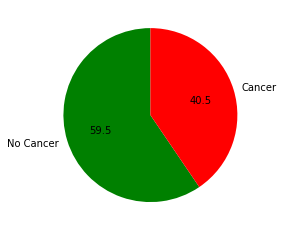

In [10]:
plt.pie(df.label.value_counts(), labels=['No Cancer', 'Cancer'], 
        colors=['g','r'], autopct='%1.1f', startangle=90)
plt.show()

### Count the data using numerical method

In [11]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [12]:
class Dataset(Dataset):
    
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

### Transformation

In [13]:
transform_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.7025, 0.5463, 0.6965],std=[0.2389, 0.2821, 0.2163])])

transform_test = transforms.Compose([transforms.ToPILImage(), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.7025, 0.5463, 0.6965],std=[0.2389, 0.2821, 0.2163])])



### Transform ımage to tensor

In [14]:
train_dataset = Dataset(df_data=df, data_dir="/content/kaggle/train/train/", transform=transform_train)
test_dataset = Dataset(df_data=sample_sub, data_dir="/content/kaggle/train/test/", transform=transform_test)

### Read the test and train

In [60]:
trainloader = DataLoader(train_dataset, batch_size=256, shuffle=True,num_workers=4)
testloader= DataLoader(test_dataset, batch_size=256, shuffle=False)

### CNN Architecture

In [61]:
CNN_architecture = 'alexnet' #'resnet101' #'alexnet' #'VGG'

if CNN_architecture == 'alexnet':
  #Instatiate model
  #net = tv.models.vgg16(pretrained=True)
  net = tv.models.alexnet(pretrained=True)
  
  #Now we adapt the AlexNet:
  net.classifier[1] = nn.Linear(9216,1024)

  

  #Updating the second classifier
  net.classifier[4] = nn.Linear(1024,256)
  
  

  #Updating the third and the last classifier that is the output layer of the network.
  net.classifier[6] = nn.Linear(256,2)
  

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### See the model

In [63]:
model = net.to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

### Train and Test

In [64]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device,criterion, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
            # get samples
            data, target = data.to(device), target.to(device)

            # Init
            optimizer.zero_grad()
            # Predict
            y_pred = model(data)

            # Calculate loss
            loss = criterion(y_pred, target)
            train_losses.append(loss)

            # Backpropagation
            loss.backward()
            optimizer.step()

            
            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            
            # Update pbar-tqdm
            pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
            train_acc.append(100*correct/processed)

def test(model, device,criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
       
    test_acc.append(100. * correct / len(test_loader.dataset))



### See the accuracy of test and train

In [65]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

EPOCHS = 5

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device,criterion,trainloader, optimizer, epoch)
    test(model, device,criterion,testloader)

cuda
EPOCH: 0


Loss=0.2937075197696686 Batch_id=859 Accuracy=86.18: 100%|██████████| 860/860 [03:38<00:00,  3.93it/s]



Test set: Average loss: 0.0043, Accuracy: 37367/57458 (65.03%)

EPOCH: 1


Loss=0.21048325300216675 Batch_id=859 Accuracy=89.46: 100%|██████████| 860/860 [03:44<00:00,  3.83it/s]



Test set: Average loss: 0.0044, Accuracy: 38002/57458 (66.14%)

EPOCH: 2


Loss=0.21808257699012756 Batch_id=859 Accuracy=90.58: 100%|██████████| 860/860 [03:42<00:00,  3.87it/s]



Test set: Average loss: 0.0040, Accuracy: 38378/57458 (66.79%)

EPOCH: 3


Loss=0.3949166238307953 Batch_id=859 Accuracy=91.18: 100%|██████████| 860/860 [03:44<00:00,  3.82it/s]



Test set: Average loss: 0.0047, Accuracy: 37972/57458 (66.09%)

EPOCH: 4


Loss=0.21944105625152588 Batch_id=859 Accuracy=91.69: 100%|██████████| 860/860 [03:49<00:00,  3.75it/s]



Test set: Average loss: 0.0048, Accuracy: 38250/57458 (66.57%)

